# Learning Representations by Recirculation

In [1]:
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(0)

## Recirculation Implementation

### Activation Functions
In the paper the only activation function described is the logistic function. They said that other smooth monotonic functions will work too. Here I implemented the logistic function, and also other smooth monotonic functions.
* Logistic:
$$
    f(x) = \frac{1}{1 + e^{-x}}
$$
* Linear:$$ f(x) = x $$
* Tanh:
$$
    f(x) = \frac{e^{2x} - 1}{e^{2x} + 1}
$$
* Rectified Linear Unit (ReLU): $$ f(x) = x^+ = max(0, x) $$
* Leaky Rectified Linear Unit (Leak ReLU):
$$
f(x)=
    \begin{cases}
    x  &\quad \text{if } x>0\\
    ax & \quad \text{if } x<0
    \end{cases}
$$

In [3]:
def logistic(x: np.ndarray):
    return 1 / (1 + np.exp(-x))


def linear(x: np.ndarray):
    return x


def tanh(x: np.ndarray):
    return (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)


def relu(x: np.ndarray):
    return np.maximum(x, 0)


def leaky_relu(x: np.ndarray, a: float = 0.01):
    return np.where(x > 0, x, x * a)


### Weight Initializers
In the paper, the weights are selected using a uniform distribution between $-0.5$ and $0.5$.

In [4]:
def uniform_initializer(low, high, shape):
    return np.random.uniform(low, high, shape)

### Error Metrics
Metric used in the paper is squared reconstruction error.
$$ E = \frac{1}{2}\sum_{\substack{k}}[y_k(2)-y_k(0)]^2 $$

In [5]:
def squared_reconstruction_error(y1, y2):
    return 1 / 2 * np.sum((y1 - y2) ** 2)

### Util Functions
In the paper, each unit has a threshold term which is eliminated by adding an extra input to the unit with its activity fixed at 1. The `add_bias` function does that.

In [6]:
def add_bias(x):
    shape = list(x.shape)
    shape[-1] = 1
    bias = np.ones(shape)
    return np.hstack((x, bias))

## Recirculation Algorithm
Here I implemented the Recirculation algorithm in the `Recirculation` class.

Now I will give a brief description on the algorithm.

Recirculation uses a Neural Network; however, there are some differences between recirculation and a simple Neural Network. Recirculation is used for encoding it's input and learn codes in the hidden unit. It's output should be the same as the input, however this isn't a must in a simple neural network. The other difference between Recirculation and a simple NN is that Recirculation doesn't use the backpropagation.

**Learning process in Recirculation**

The forward pass in Recirculation consists of 2 phases: first and second pass. The first pass is similar to the forward pass in a NN. Each layers input is $x_j$ and its output is $y_j$:
$$ x_j = \sum_{\substack{i}}y_i w_{ji} - \theta_j $$
$$ y_j = \sigma(x_j) $$
where $x_j$ is the input of the unit, $y_i$ is output of previous unit, $w_{ji}$ is the weight connecting previous unit to this one, $\theta_j$ is the bias (as said, this bias is removed by adding an extra input to the unit), and $\sigma$ is the units' activation function.

In the second pass, an average between the original input and the reconstructed output is sent through the network. This is computed by calculating a weighted average between the 2 values.
$$ y_i(2) = \lambda y_i(0) + (1 - \lambda) x_i(2) $$
This images shows these passes.

![image](images/recirculation_passes.png)

After this the weights are updated. The difference between the initial input and the input in the second pass are the derivatives that are used to update the weights. Here is how it is computed.
$$ \Delta w_{ij} = \epsilon y_j(1)[y_i(0)-y_i(2)] $$
$$ \Delta w_{ji} = \epsilon y_i(2)[y_j(1)-y_j(3)] $$
Where the first one is for the weight connecting the hidden units to the output units and the second one is for the weights connecting the input unit to the hidden units.


In [7]:
class Recirculation:
    ACTIVATIONS = {
        'logistic': logistic,
        'linear': linear,
        'tanh': tanh,
        'relu': relu,
        'leaky_relu': leaky_relu,
    }

    INITIALIZERS = {
        'uniform': uniform_initializer,
    }

    def __init__(self, input_len: int, hidden_units: Union[int, list], regression_rate: float, learning_rate: float,
                 activation_function: str, weight_initializer: str, low_weight_range: float = -0.5,
                 high_weight_range: float = 0.5):
        if type(hidden_units) is int:
            hidden_units = [hidden_units]

        self.activation_function = self.ACTIVATIONS[activation_function]
        self.weight_initializer = self.INITIALIZERS[weight_initializer]
        self.regression_rate = regression_rate
        self.learning_rate = learning_rate

        self.layer_shapes = [input_len] * 2
        for unit in hidden_units:
            self.layer_shapes.insert(-1, unit)

        self.layer_count = len(self.layer_shapes)

        self.weights = []
        for i in range(self.layer_count - 1):
            self.weights.append(
                self.weight_initializer(
                    low_weight_range, high_weight_range,
                    # adding one to the first shape is because of the bias
                    (self.layer_shapes[i] + 1, self.layer_shapes[i + 1])
                )
            )

    def fit(self, x: np.ndarray, epoch: int = 100, loging: str = 'low') -> dict:
        if loging not in ['low', 'high']:
            raise ValueError('Incorrect loging value. It can be either low or high.')

        history = {
            'error': [],
        }
        if loging == 'high':
            history['weights'] = [self.weights]
            history['prediction_history'] = [self.predict(x)]
            history['predicted_classes_history'] = [self.predict_class(x)]

        for _ in range(epoch):
            layer_outputs = [x]
            # first pass
            # calculate hidden layer outputs (based on equation 1, 2)
            for i in range(self.layer_count - 2):
                layer_outputs.append(
                    self.activation_function(
                        add_bias(layer_outputs[-1]) @ self.weights[i]
                    )
                )
            # calculate output with regression (based on equation 5)
            layer_outputs.append(
                self.regression_rate * layer_outputs[0] + (1 - self.regression_rate) *
                self.activation_function(
                    add_bias(layer_outputs[-1]) @ self.weights[-1]
                )
            )
            # note: the above statement can be inside the for loop below but this is more readable

            # second pass
            # calculate hidden layer outputs (based on equation 6)
            for i in range(1, self.layer_count - 1):
                layer_outputs.append(
                    self.regression_rate * layer_outputs[i] + (1 - self.regression_rate) *
                    self.activation_function(
                        add_bias(layer_outputs[-1]) @ self.weights[i - 1]
                    )
                )

            # compute reconstruction error
            error = squared_reconstruction_error(layer_outputs[0], layer_outputs[self.layer_count - 1])

            # updating weights (based on equations 3, 4)
            for i in range(self.layer_count - 1):
                delta_w = self.learning_rate * add_bias(layer_outputs[i + 1]).T @ (
                        layer_outputs[i] - layer_outputs[i + 2])
                self.weights[len(self.weights) - 1 - i] += delta_w

            # update history
            history['error'].append(error)
            if loging == 'high':
                history['weights'].append(self.weights)
                history['prediction_history'].append(self.predict(x))
                history['predicted_classes_history'].append(self.predict_class(x))

        return history

    def predict(self, x: np.ndarray) -> np.ndarray:
        layer_output = [x]
        for i in range(self.layer_count - 1):
            layer_output.append(
                self.activation_function(
                    add_bias(layer_output[-1]) @ self.weights[i]
                )
            )
        return layer_output[-1]

    def predict_class(self, x: np.ndarray) -> np.ndarray:
        pred = self.predict(x)
        classes = np.zeros_like(pred)
        classes[np.arange(len(classes)), pred.argmax(axis=1)] = 1
        return classes

    def encode(self, x):
        layer_output = [x]
        for i in range(self.layer_count - 2):
            layer_output.append(
                self.activation_function(
                    add_bias(layer_output[-1]) @ self.weights[i]
                )
            )
        return layer_output[-1]


## Testing

### Parameters
Here the parameters are set as they are described in the paper. Our input is a $4*4$ matrix so input length is 4. $\epsilon$(learning rate) is set to 20 and $\lambda$(regression rate) is set to 0.75. We have one hidden layer with 2 units. Weights are selected from a uniform distribution between $-0.5, 0.5$. Activation function is the logistic function.

This is the structure of the network.

![image](images/nn_structure.png)

In [8]:
parameters = {
    'input_len': 4,
    'hidden_units': 2,
    'regression_rate': 0.75,
    'learning_rate': 20,
    'activation_function': 'logistic',
    'weight_initializer': 'uniform',
    'low_weight_range': -0.5,
    'high_weight_range': 0.5,
}

In [9]:
r = Recirculation(**parameters)

In [10]:
x = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
])

In [11]:
history = r.fit(x, loging='high')

Plotting the error history to see the model's performance.

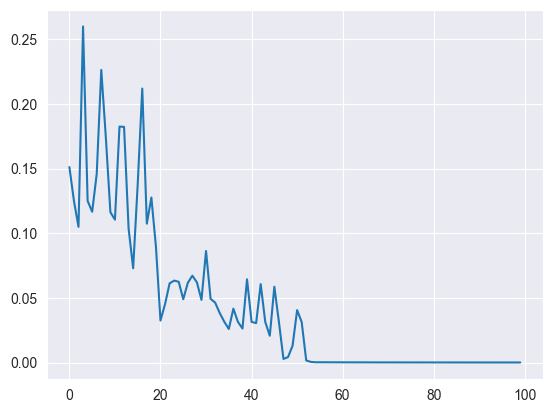

In [12]:
plt.plot(np.arange(100), np.array(history['error']))

### Predictions

Each row is the output relating to the same row in x defined above. As it is seen, the output is very close to the input. The cell that should be 1 is bigger than 0.98 and the cells that should be 0 are smaller than 1e-2.

In [13]:
r.predict(x)

array([[9.80088607e-01, 3.00000946e-03, 4.18966443e-07, 7.34606783e-03],
       [1.43139650e-02, 9.93833971e-01, 5.64062353e-03, 3.96321582e-07],
       [2.72210982e-06, 4.25881148e-03, 9.88556782e-01, 2.05122932e-03],
       [1.23488574e-02, 2.58344699e-08, 4.39139643e-03, 9.90389260e-01]])

This function turns the biggest element to 1 and the others to 0. We can see it is the same as the input.

In [14]:
r.predict_class(x)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

This function returns the output of the final hidden layer, so we can see the representations for each input.

In [15]:
r.encode(x)

array([[0.9410874 , 0.87564743],
       [0.90996569, 0.06073768],
       [0.05522127, 0.09080284],
       [0.06059903, 0.96532985]])

Let's do the test for 100 times to see average number of weight updates to get an error bellow 0.05. The paper tested the average for the error bellow 0.1 but looking at the error graph above, we see that the model achieves 0.1 error in the first few epochs but because of the high regression rate, it's not stable. However, it is more stable around 0.05 error.

In [16]:
indexes = []
for _ in range(100):
    r = Recirculation(**parameters)
    history = r.fit(x)
    error_array = np.array(history['error'])
    indexes.append(np.argmax(error_array < 0.05))
print(np.average(indexes))

21.6
